# データ分析とモデル作成sample

## 内容

- タイタニックのデータを使用して，データ分析とモデル作成を行う

### 各カラムの意味

1. **survived**: 乗客が生存したかどうか（0 = 死亡, 1 = 生存）。
2. **pclass**: 乗客のチケットクラス（1 = 1等, 2 = 2等, 3 = 3等）。
3. **sex**: 乗客の性別（male = 男性, female = 女性）。
4. **age**: 乗客の年齢。NaNの値も含まれ、年齢が不明な場合があります。
5. **sibsp**: 兄弟姉妹または配偶者の数。乗船した兄弟姉妹または配偶者の数を示します。
6. **parch**: 両親または子供の数。乗船した親または子供の数を示します。
7. **fare**: 乗船料金。乗客が支払った運賃を表します。
8. **embarked**: 乗船港（C = Cherbourg, Q = Queenstown, S = Southampton）。
9. **class**: チケットのクラスを文字列で示したもの（'First', 'Second', 'Third'）。
10. **who**: 乗客のカテゴリー（'man', 'woman', 'child'）。
11. **adult_male**: 乗客が成人男性かどうか（True = 成人男性, False = それ以外）。
12. **deck**: 乗客が乗っていたデッキ（甲板）のレベル。NaNの値も多く含まれます。
13. **embark_town**: 乗船した港の町（'Cherbourg', 'Queenstown', 'Southampton'）。
14. **alive**: 生存か死亡かを文字列で示したもの（'yes' = 生存, 'no' = 死亡）。
15. **alone**: 乗客が単独で乗船したかどうか（True = 単独, False = 家族や他の人と一緒）。

# Load modules

ライブラリ読み込み

In [1]:
!pip install japanize_matplotlib

In [2]:
# ライブラリ読み込み
import sys, os
import time
import gc
from datetime import datetime as dt
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import japanize_matplotlib

import joblib
import re # 正規表現

import seaborn as sns

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV

# 評価関数
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [3]:
gc.collect()

4

# Configure

## Google Colab用設定

In [4]:
# 各自書き換えてください
current_project_dpath = '/content/drive/MyDrive/work/matsue_ct/20240831_データ分析研修'
print(current_project_dpath)

/content/drive/MyDrive/work/matsue_ct/20240831_データ分析研修


In [5]:
from google.colab import drive

drive.mount('/content/drive')
os.chdir(current_project_dpath)

# 現在のディレクトリを確認
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/work/matsue_ct/20240831_データ分析研修


## pandas.DataFrameの表示行数・列数を変更

In [6]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## warningの表示を削除

In [7]:
# warningの削除
import warnings
warnings.filterwarnings('ignore')

## random seed
- random系moduleのseed値を設定する.

In [8]:
# random系moduleのseed値を設定
random.seed(57)
np.random.seed(57)

# Constants

## date

In [9]:
today_dt = dt.today()
today_str = dt.strftime(today_dt, '%Y%m%d')
today_str

'20240830'

## paths

In [10]:
input_dpath = './input/'
output_dpath = './output/'

# Functions

## 数値計算

### 数字を四捨五入で丸める

In [11]:
def pro_round(num, ndigits=0):
    """
    数字を四捨五入で丸める。

    Args:
        num: int or float
            丸めたい数字。

        ndigits: int, optional(default=0)
            丸めた後の小数部分の桁数。

    Returns:
        rounded: int or float
            丸めた後の数字。
    """
    num *= 10 ** ndigits
    rounded = ( 2* num + 1 ) // 2
    rounded /= 10 ** ndigits

    if ndigits == 0:
        rounded = int(rounded)

    return rounded

### スタージェスの公式

In [12]:
def sturges_rule(num):
    """
    スタージェスの公式を用いて、
    サンプルサイズから階級(カテゴリ、ビン(bins))の数を計算する。
    公式のTeX表記: \[bins = 1 + \log_2{N} \nonumber \]

    Args:
        num: int
            サンプルサイズ。原則1以上の整数を想定。

    Returns:
        n_bins: int
            スタージェスの公式から導かれた適切な階級の数。
    """
    # numが0以下の時は1を返す
    if num <= 0:
        num = 1
        return 1

    # スタージェスの公式
    n_bins = int(pro_round(1 + np.log2(num), 0))

    return n_bins

# Load data

## データ準備

In [13]:
# タイタニックデータ
# seabornからロード
titanic_df = sns.load_dataset('titanic')

# Explatory data analysis

## 基本的な情報を確認

### 各カラムの意味

1. **survived**: 乗客が生存したかどうか（0 = 死亡, 1 = 生存）。
2. **pclass**: 乗客のチケットクラス（1 = 1等, 2 = 2等, 3 = 3等）。
3. **sex**: 乗客の性別（male = 男性, female = 女性）。
4. **age**: 乗客の年齢。NaNの値も含まれ、年齢が不明な場合があります。
5. **sibsp**: 兄弟姉妹または配偶者の数。乗船した兄弟姉妹または配偶者の数を示します。
6. **parch**: 両親または子供の数。乗船した親または子供の数を示します。
7. **fare**: 乗船料金。乗客が支払った運賃を表します。
8. **embarked**: 乗船港（C = Cherbourg, Q = Queenstown, S = Southampton）。
9. **class**: チケットのクラスを文字列で示したもの（'First', 'Second', 'Third'）。
10. **who**: 乗客のカテゴリー（'man', 'woman', 'child'）。
11. **adult_male**: 乗客が成人男性かどうか（True = 成人男性, False = それ以外）。
12. **deck**: 乗客が乗っていたデッキ（甲板）のレベル。NaNの値も多く含まれます。
13. **embark_town**: 乗船した港の町（'Cherbourg', 'Queenstown', 'Southampton'）。
14. **alive**: 生存か死亡かを文字列で示したもの（'yes' = 生存, 'no' = 死亡）。
15. **alone**: 乗客が単独で乗船したかどうか（True = 単独, False = 家族や他の人と一緒）。

In [14]:
# 全カラムのリスト
titanic_df.columns.tolist()

['survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alive',
 'alone']

### データの中身を確認する

In [15]:
# 上から3行読む
titanic_df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


In [16]:
# head()の中を何も指定しないと5行読み込む扱い
titanic_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [17]:
# tail()は最後の5行
titanic_df.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
886,0,2,male,27.0,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.00,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.75,Q,Third,man,True,NaN,Queenstown,no,True


In [18]:
# (行数, 列数)を確認
titanic_df.shape

(891, 15)

## データ型を確認

In [19]:
titanic_df.dtypes

,0
survived,int64
pclass,int64
sex,object
age,float64
sibsp,int64
parch,int64
fare,float64
embarked,object
class,category
who,object


In [20]:
# 数値列のみを含むデータフレームを作成
numeric_df = titanic_df.select_dtypes(include=['number'])
numeric_df.head()

,survived,pclass,age,sibsp,parch,fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


## 基本統計量を見る

In [21]:
# 基本統計量を見る
titanic_df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 相関を見る

In [22]:
corr_df = numeric_df.corr()
corr_df

,survived,pclass,age,sibsp,parch,fare
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


<Axes: >

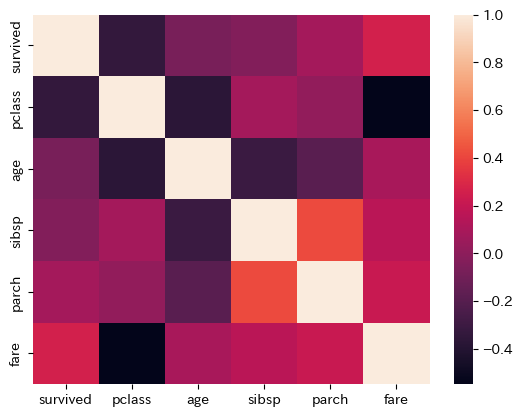

In [23]:
# ヒートマップで表示も可能
sns.heatmap(corr_df)

### 相関係数(の絶対値)が高い順に並べる

In [24]:
# 目的変数
target = 'survived'

In [25]:
# 相関係数の絶対値が高い順に並べる
corr_df0 = corr_df[[target]]
corr_df0['abs_corr'] = corr_df0[target].abs()
corr_df0 = corr_df0.sort_values(by='abs_corr', ascending=False)
corr_df0

,survived,abs_corr
survived,1.000000,1.000000
pclass,-0.338481,0.338481
fare,0.257307,0.257307
parch,0.081629,0.081629
age,-0.077221,0.077221
sibsp,-0.035322,0.035322


以下2つは同じ
titanic_df['pclass']
titanic_df.pclass

## 度数を見てみる

### survived

In [26]:
titanic_df.survived.value_counts()

,count
survived,
0,549
1,342


### pclass

In [27]:
titanic_df.pclass.value_counts()

,count
pclass,
3,491
1,216
2,184


### 性別

In [28]:
titanic_df.sex.value_counts()

,count
sex,
male,577
female,314


## 各変数の尺度を確認することが重要

参考: http://www.gen-info.osaka-u.ac.jp/MEPHAS/express/express0.html  
  
- 順序尺度以上：順序尺度・間隔尺度・比例尺度のいずれかである場合です  
- 間隔尺度以上：間隔尺度・比例尺度のいずれかである場合です  
  
### 名義尺度
単に区別するために用いられている尺度。  
例えば、血液型でＡ型・Ｂ型・Ｏ型・ＡＢ型を、 それぞれ０・１・２・３と数値に対応させたもの。  
これらの変数の平均値を求めてもまったく意味がありません。  
  
### 順序尺度
大小関係にのみ意味がある尺度。  
例えば、治療効果の判定において、 悪化・不変・改善・著効を、それぞれ-１・０・１・２と数値に対応させたもの。  
平均値は定義できないが中央値は定義できます。  
  
### 間隔尺度
数値の差のみに意味がある尺度。  
「距離尺度」とも呼びます。順序尺度の性質も備えています。  
例えば、温度が10℃から15℃になったときに、50％の温度上昇があったとはいいません。 温度が10℃から15℃になったときも、100℃から105℃になったときも、 ともに５℃の温度上昇です。そして、５℃という数値には意味があります。  
  
### 比例尺度
数値の差とともに数値の比にも意味がある尺度。  
「比尺度」とも呼びます。順序尺度・間隔尺度の性質も備えています。  
例えば、体重は50kgから60kgになったときと、100kgから110kgになったときとは、 同じ10kgの増加であっても、前者は20％増、後者は10％増です。 また、比が定義できるということは絶対零点を持つことと同じことを表します。  

## Excelで保存してみる

to_excel(ファイル名, index=(indexをつけるかどうか))

In [29]:
titanic_fpath = f'{input_dpath}titanic_{today_str}.xlsx'
titanic_fpath

'./input/titanic_20240830.xlsx'

In [30]:
# 保存する
titanic_df.to_excel(titanic_fpath, index=False)

## Excelを読み込む

In [31]:
# 読み込む
nakami_df = pd.read_excel(titanic_fpath)
nakami_df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


# Preprocessing

In [32]:
df = titanic_df.copy()
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


In [33]:
df.shape

(891, 15)

## leakage対策

leakageについて  
https://www.datarobot.com/jp/wiki/target-leakage/

### aliveがsurvivedの情報を含んでいるのでaliveカラムを削除

In [34]:
# 重複した行を削除
df[[target, 'alive']].drop_duplicates()

,survived,alive
0,0,no
1,1,yes


In [35]:
df = df.drop('alive', axis=1)
df.head(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True


## 欠損処理

### 今回は簡易的に考えるため欠損は削除する

In [36]:
df.shape

(891, 14)

In [37]:
df = df.dropna(
    axis=0,
    subset=[
        'survived',
        'pclass',
        'age',
        'sibsp',
        'parch',
        'fare',
        'class',
        'who',
        'adult_male'
    ]
)

In [38]:
df.shape

(714, 14)

## 型を修正

In [39]:
df.columns.tolist()

['survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alone']

In [40]:
int_cols = [
    'pclass',
    'age',
    'sibsp',
    'parch'
]

In [41]:
for col in int_cols:

    # int型にする
    df[col] = df[col].astype(int)

## 階級に分ける

### 階級に分けるカラムの指定

In [42]:
cls_cols = ['age', 'fare']

### 階級数をスタージェスの公式で計算

In [43]:
n_class = sturges_rule(len(df))
n_class

10

### 階級に分ける場合

- 参考: [pandasのcut, qcut関数でビニング処理（ビン分割）](https://note.nkmk.me/python-pandas-cut-qcut-binning/)

In [44]:
for_class_df = df.copy()

In [45]:
for_class_df['age'].value_counts().head()

,count
age,
24,31
22,27
28,27
30,27
18,26


In [46]:
# ユニーク数の確認
for_class_df['age'].nunique()

71

In [47]:
# 階級に分ける(ビニング処理)
for_class_df['age_splitted'] = pd.cut(for_class_df['age'], bins=n_class)
for_class_df['age_splitted'] = for_class_df['age_splitted'].apply(lambda x: str(x).replace(',', '_').replace(' ', ''))

In [48]:
for_class_df['age_splitted'].value_counts().head()

,count
age_splitted,
(16.0_24.0],178
(24.0_32.0],170
(32.0_40.0],118
(40.0_48.0],68
(-0.08_8.0],54


In [49]:
# ユニーク数の確認
for_class_df['age_splitted'].nunique()

10

In [50]:
for_class_df['fare'].value_counts().head()

,count
fare,
13.0000,41
26.0000,30
8.0500,29
10.5000,24
7.8958,23


In [51]:
# ユニーク数の確認
for_class_df['fare'].nunique()

220

In [52]:
# 階級に分ける(ビニング処理)
for_class_df['fare_splitted'] = pd.cut(for_class_df['fare'], bins=n_class)
for_class_df['fare_splitted'] = for_class_df['fare_splitted'].apply(lambda x: str(x).replace(',', '_').replace(' ', ''))

In [53]:
for_class_df['fare_splitted'].value_counts().head()

,count
fare_splitted,
(-0.512_51.233],577
(51.233_102.466],89
(102.466_153.699],28
(204.932_256.165],9
(256.165_307.398],6


In [54]:
# ユニーク数の確認
for_class_df['fare_splitted'].nunique()

7

## ダミー変数化

### カテゴリ変数のカラムの指定

In [55]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alone
0,0,3,male,22,1,0,7.2500,S,Third,man,True,NaN,Southampton,False
1,1,1,female,38,1,0,71.2833,C,First,woman,False,C,Cherbourg,False
2,1,3,female,26,0,0,7.9250,S,Third,woman,False,NaN,Southampton,True
3,1,1,female,35,1,0,53.1000,S,First,woman,False,C,Southampton,False
4,0,3,male,35,0,0,8.0500,S,Third,man,True,NaN,Southampton,True


In [56]:
df.nunique()

,0
survived,2
pclass,3
sex,2
age,71
sibsp,6
parch,7
fare,220
embarked,3
class,3
who,3


In [57]:
# カテゴリ変数のカラム
cate_cols = df.columns.tolist()
cate_cols = list(set(cate_cols) - {target, 'age', 'fare'})
cate_cols

['adult_male',
 'embark_town',
 'who',
 'pclass',
 'class',
 'sex',
 'parch',
 'alone',
 'sibsp',
 'deck',
 'embarked']

### ダミー変数化

In [58]:
df.columns.tolist()

['survived',
 'pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alone']

In [59]:
df = pd.get_dummies(
    df,
    dummy_na=True,
    columns=cate_cols,
    dtype=int
)
df.head(3)

,survived,age,fare,adult_male_False,adult_male_True,adult_male_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,who_child,who_man,who_woman,who_nan,pclass_1.0,pclass_2.0,pclass_3.0,pclass_nan,class_First,class_Second,class_Third,class_nan,sex_female,sex_male,sex_nan,parch_0.0,parch_1.0,parch_2.0,parch_3.0,parch_4.0,parch_5.0,parch_6.0,parch_nan,alone_False,alone_True,alone_nan,sibsp_0.0,sibsp_1.0,sibsp_2.0,sibsp_3.0,sibsp_4.0,sibsp_5.0,sibsp_nan,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embarked_C,embarked_Q,embarked_S,embarked_nan
0,0,22,7.2500,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1,1,38,71.2833,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,1,26,7.9250,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [60]:
df.shape

(714, 55)

In [61]:
# カラムの確認
df.columns.tolist()

['survived',
 'age',
 'fare',
 'adult_male_False',
 'adult_male_True',
 'adult_male_nan',
 'embark_town_Cherbourg',
 'embark_town_Queenstown',
 'embark_town_Southampton',
 'embark_town_nan',
 'who_child',
 'who_man',
 'who_woman',
 'who_nan',
 'pclass_1.0',
 'pclass_2.0',
 'pclass_3.0',
 'pclass_nan',
 'class_First',
 'class_Second',
 'class_Third',
 'class_nan',
 'sex_female',
 'sex_male',
 'sex_nan',
 'parch_0.0',
 'parch_1.0',
 'parch_2.0',
 'parch_3.0',
 'parch_4.0',
 'parch_5.0',
 'parch_6.0',
 'parch_nan',
 'alone_False',
 'alone_True',
 'alone_nan',
 'sibsp_0.0',
 'sibsp_1.0',
 'sibsp_2.0',
 'sibsp_3.0',
 'sibsp_4.0',
 'sibsp_5.0',
 'sibsp_nan',
 'deck_A',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 'deck_F',
 'deck_G',
 'deck_nan',
 'embarked_C',
 'embarked_Q',
 'embarked_S',
 'embarked_nan']

## 目的変数と説明変数で分ける

In [62]:
df.columns.tolist()

['survived',
 'age',
 'fare',
 'adult_male_False',
 'adult_male_True',
 'adult_male_nan',
 'embark_town_Cherbourg',
 'embark_town_Queenstown',
 'embark_town_Southampton',
 'embark_town_nan',
 'who_child',
 'who_man',
 'who_woman',
 'who_nan',
 'pclass_1.0',
 'pclass_2.0',
 'pclass_3.0',
 'pclass_nan',
 'class_First',
 'class_Second',
 'class_Third',
 'class_nan',
 'sex_female',
 'sex_male',
 'sex_nan',
 'parch_0.0',
 'parch_1.0',
 'parch_2.0',
 'parch_3.0',
 'parch_4.0',
 'parch_5.0',
 'parch_6.0',
 'parch_nan',
 'alone_False',
 'alone_True',
 'alone_nan',
 'sibsp_0.0',
 'sibsp_1.0',
 'sibsp_2.0',
 'sibsp_3.0',
 'sibsp_4.0',
 'sibsp_5.0',
 'sibsp_nan',
 'deck_A',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 'deck_F',
 'deck_G',
 'deck_nan',
 'embarked_C',
 'embarked_Q',
 'embarked_S',
 'embarked_nan']

In [63]:
data_x = df.drop(labels=[target], axis=1)
data_y = df[target]

## trainとtestに分割

In [64]:
train_x, test_x, train_y, test_y = train_test_split(
    data_x,
    data_y,
    random_state=57,
    test_size=0.3
)

In [65]:
train_x.head()

,age,fare,adult_male_False,adult_male_True,adult_male_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,who_child,who_man,who_woman,who_nan,pclass_1.0,pclass_2.0,pclass_3.0,pclass_nan,class_First,class_Second,class_Third,class_nan,sex_female,sex_male,sex_nan,parch_0.0,parch_1.0,parch_2.0,parch_3.0,parch_4.0,parch_5.0,parch_6.0,parch_nan,alone_False,alone_True,alone_nan,sibsp_0.0,sibsp_1.0,sibsp_2.0,sibsp_3.0,sibsp_4.0,sibsp_5.0,sibsp_nan,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embarked_C,embarked_Q,embarked_S,embarked_nan
377,27,211.5000,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
827,1,37.0042,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
89,24,8.0500,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
302,19,0.0000,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
526,50,10.5000,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [66]:
print('train_x.shape:', train_x.shape)
print('test_x.shape:', test_x.shape)
print('train_y.shape:', train_y.shape)
print('test_y.shape:', test_y.shape)

train_x.shape: (499, 54)
test_x.shape: (215, 54)
train_y.shape: (499,)
test_y.shape: (215,)


## 中間データを出力

In [67]:
pp_data_dict = {
    'train_x': train_x,
    'train_y': train_y,
    'test_x': test_x,
    'test_y': test_y
}

In [68]:
# 圧縮ファイルとして出力
joblib.dump(
    pp_data_dict,
    f'{input_dpath}pp_titanic_data_dict.pkl3',
    compress=3
)

['./input/pp_titanic_data_dict.pkl3']

# Decision Tree Classifier

## create model

In [69]:
dtc = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_leaf=5,
    random_state=57
)
dtc.fit(train_x, train_y)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=57)

## 寄与度分析

In [70]:
# 説明変数
features = train_x.columns

# 寄与率
dtc_importances = dtc.feature_importances_

,feature,importance
2,adult_male_False,0.409436
1,fare,0.211985
15,pclass_3.0,0.210533
0,age,0.120772
36,sibsp_1.0,0.013005
18,class_Second,0.011265
26,parch_2.0,0.005867
46,deck_E,0.005028
50,embarked_C,0.005001
7,embark_town_Southampton,0.004427


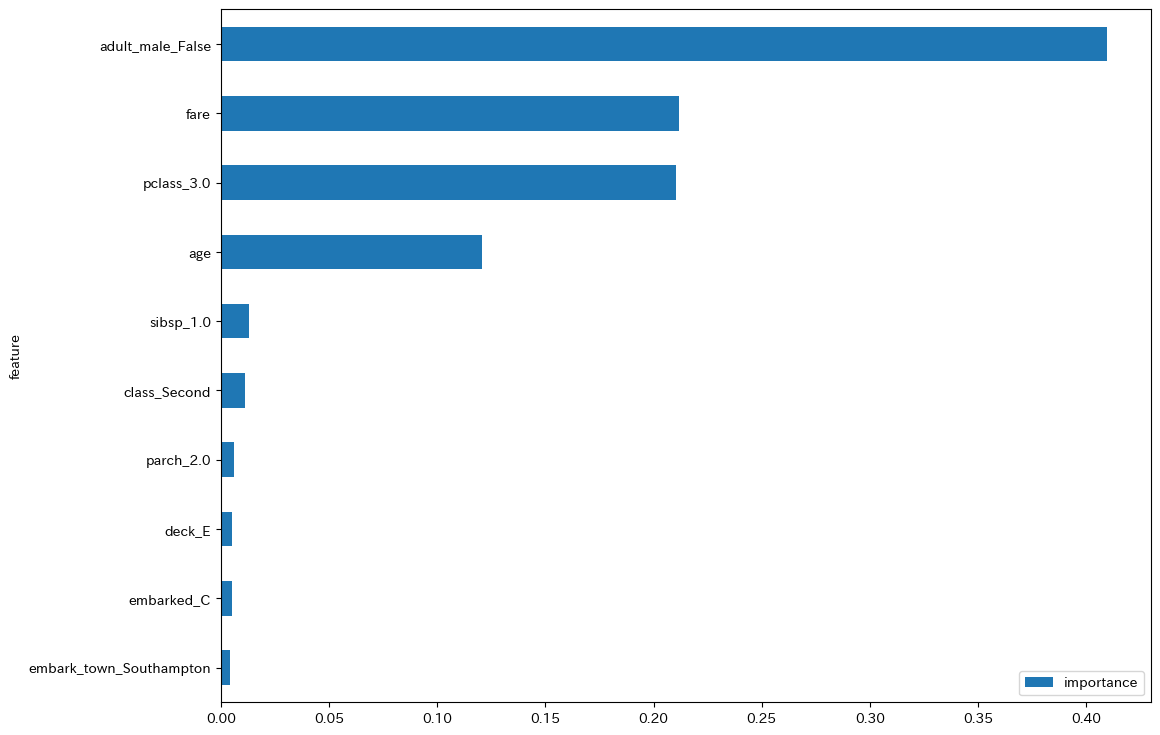

In [71]:
# dtc_importances描き方
dtc_importance_df = pd.DataFrame(
    {'feature': features, 'importance':  dtc_importances}
).sort_values(by='importance', ascending=True)

dtc_importance_df.tail(10).plot(
    x='feature',
    y='importance',
    kind='barh',
    figsize=(12,9)
)

display(dtc_importance_df.sort_values(by='importance', ascending=False).head(10))

## 木の一つを可視化する

[Text(0.5, 0.9, 'adult_male_False <= 0.5\ngini = 0.48\nsamples = 499\nvalue = [300, 199]\nclass = 死亡'),
 Text(0.25, 0.7, 'fare <= 26.269\ngini = 0.293\nsamples = 286\nvalue = [235, 51]\nclass = 死亡'),
 Text(0.125, 0.5, 'fare <= 11.0\ngini = 0.2\nsamples = 204\nvalue = [181, 23]\nclass = 死亡'),
 Text(0.0625, 0.3, 'fare <= 7.91\ngini = 0.239\nsamples = 144\nvalue = [124, 20]\nclass = 死亡'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'embark_town_Cherbourg <= 0.5\ngini = 0.095\nsamples = 60\nvalue = [57, 3]\nclass = 死亡'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'fare <= 26.775\ngini = 0.45\nsamples = 82\nvalue = [54, 28]\nclass = 死亡'),
 Text(0.3125, 0.3, 'deck_E <= 0.5\ngini = 0.32\nsamples = 10\nvalue = [2, 8]\nclass = 生存'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'class_Second <= 0.5\ngini = 0.401\nsamples = 72\nvalue = [52, 20]\nc

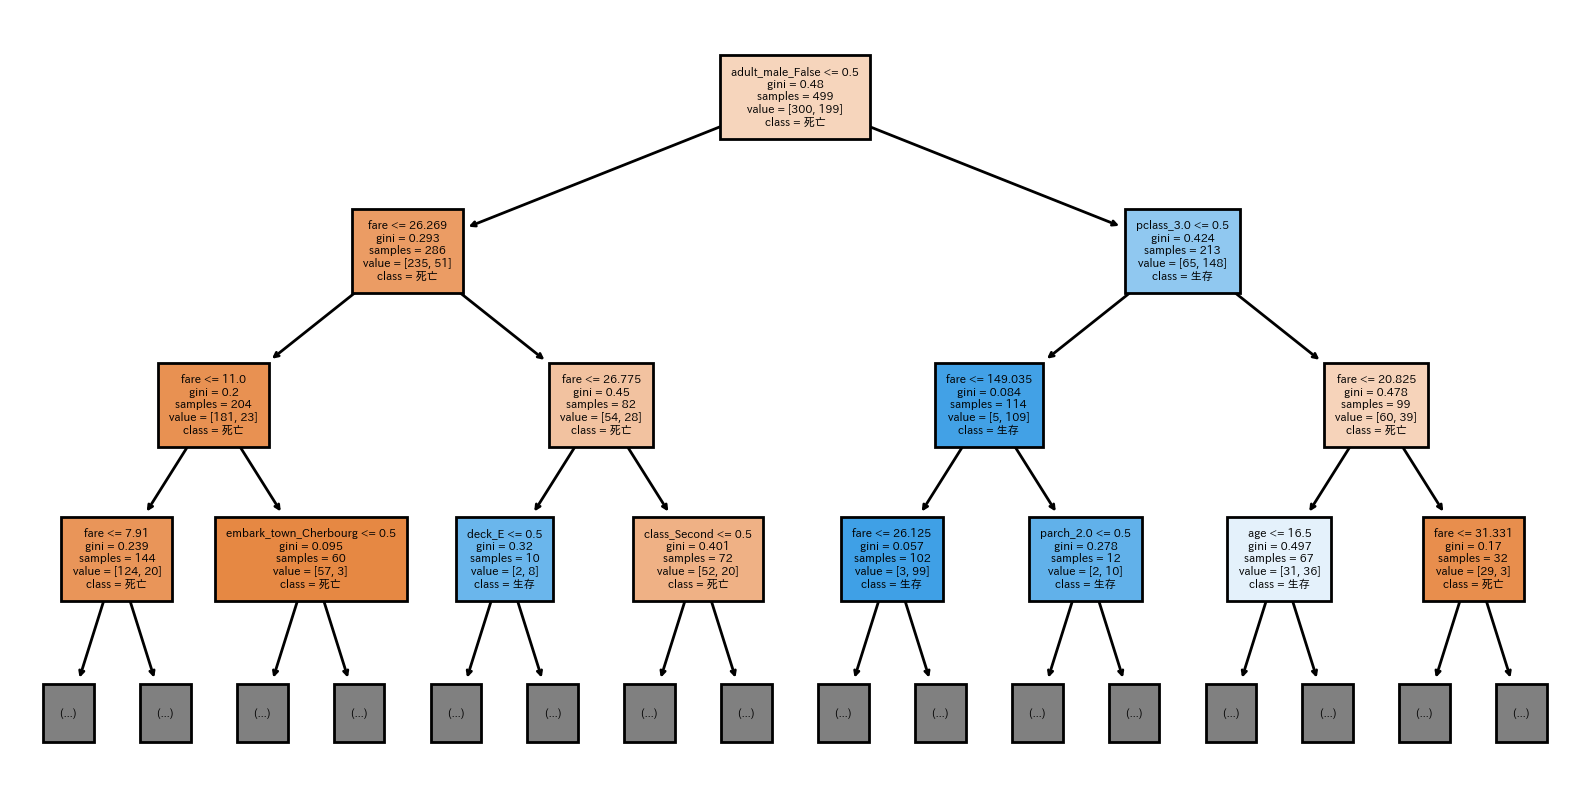

In [72]:
# 可視化の設定
plt.figure(
    figsize=(10, 5), # 描画サイズ
    facecolor='white', # 背景色
    dpi=200 # 解像度
)

# 決定木の可視化
tree.plot_tree(
    decision_tree=dtc, # 決定木モデル
    max_depth=3, # 表示する木の深さ
    feature_names=features, # 説明変数名
    class_names=['死亡', '生存'], # 目的変数の各クラス名
    fontsize=4,
    filled=True # ノードに色を付ける
)

## 精度評価

### train

In [73]:
# trainを予測
pred_train_y = dtc.predict(train_x)

# y=1である確率を予測
prob_train_y = dtc.predict_proba(train_x).T[1]

In [74]:
dtc_train_valid_df = pd.DataFrame(
    {
        'prob_y': prob_train_y,
        'pred_y': pred_train_y,
        target: train_y
    }
)
dtc_train_valid_df.head()

,prob_y,pred_y,survived
377,0.285714,0,0
827,1.000000,1,1
89,0.000000,0,0
302,0.000000,0,0
526,1.000000,1,1


In [75]:
# accuracy
dtc_train_accuracy_val = accuracy_score(
    dtc_train_valid_df[target],
    dtc_train_valid_df['pred_y']
)

# auc
dtc_train_auc_val = roc_auc_score(
    dtc_train_valid_df[target],
    dtc_train_valid_df['prob_y']
)

print('accuracy:', dtc_train_accuracy_val)
print('auc:', dtc_train_auc_val)

accuracy: 0.8717434869739479
auc: 0.9585008375209381


### test

In [76]:
# testを予測
pred_test_y = dtc.predict(test_x)

# y=1である確率を予測
prob_test_y = dtc.predict_proba(test_x).T[1]

In [77]:
dtc_test_valid_df = pd.DataFrame(
    {
        'prob_y': prob_test_y,
        'pred_y': pred_test_y,
        target: test_y
    }
)
dtc_test_valid_df.head()

,prob_y,pred_y,survived
129,0.0,0,0
189,0.0,0,0
555,0.6,1,0
483,0.0,0,1
722,0.4,0,0


In [78]:
# accuracy
dtc_test_accuracy_val = accuracy_score(
    dtc_test_valid_df[target],
    dtc_test_valid_df['pred_y']
)

# auc
dtc_test_auc_val = roc_auc_score(
    dtc_test_valid_df[target],
    dtc_test_valid_df['prob_y']
)

print('accuracy:', dtc_test_accuracy_val)
print('auc:', dtc_test_auc_val)

accuracy: 0.827906976744186
auc: 0.8481035093938318


# Random Forest

## create model

In [79]:
rfc = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    max_depth=11,
    min_samples_leaf=5,
    n_estimators=100,
    random_state=57
)
rfc.fit(train_x, train_y)

RandomForestClassifier(max_depth=11, min_samples_leaf=5, random_state=57)

## 寄与度分析

In [80]:
# 説明変数
features = train_x.columns

# 寄与率
rfc_importances = rfc.feature_importances_

,feature,importance
2,adult_male_False,0.119565
10,who_man,0.097370
21,sex_female,0.090268
3,adult_male_True,0.088141
22,sex_male,0.075910
1,fare,0.072929
15,pclass_3.0,0.071531
19,class_Third,0.062865
0,age,0.059914
11,who_woman,0.045585


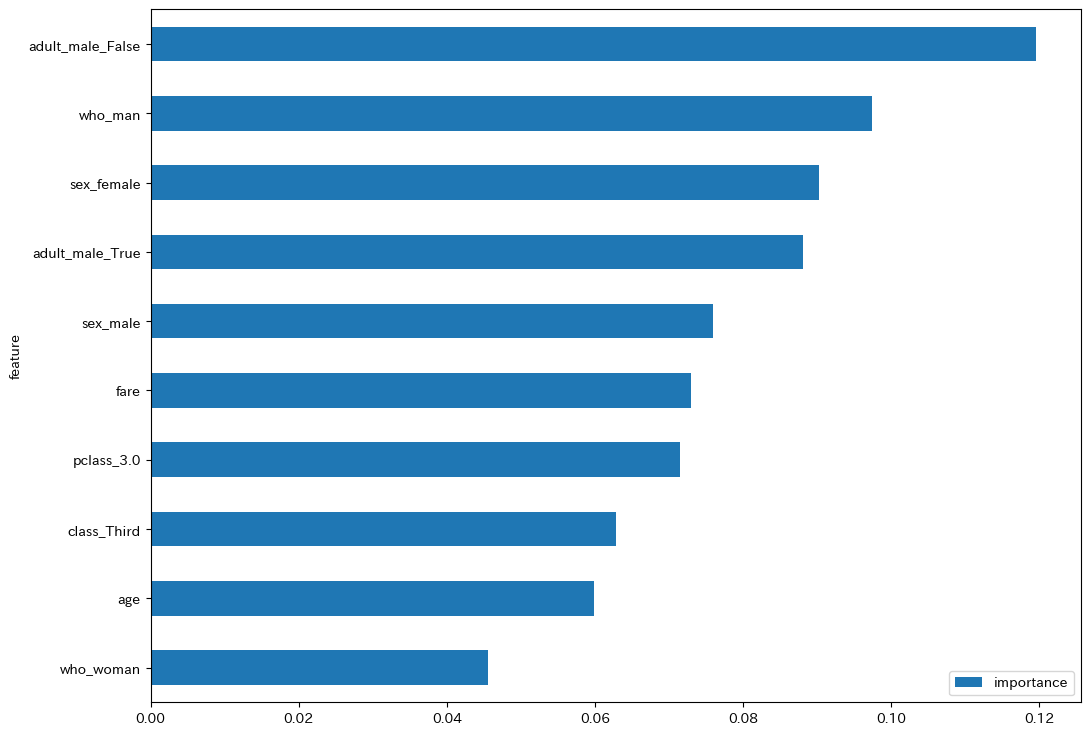

In [81]:
# rfc_importances描き方
rfc_importance_df = pd.DataFrame(
    {'feature': features, 'importance':  rfc_importances}
).sort_values(by='importance', ascending=True)

rfc_importance_df.tail(10).plot(
    x='feature',
    y='importance',
    kind='barh',
    figsize=(12,9)
)

display(rfc_importance_df.sort_values(by='importance', ascending=False).head(10))

## 木の一つを可視化する

In [82]:
# 試しに木の一つを視覚化する
estimators = rfc.estimators_
len(estimators)

100

[Text(0.5625, 0.9, 'sibsp_1.0 <= 0.5\ngini = 0.479\nsamples = 314\nvalue = [301, 198]\nclass = 死亡'),
 Text(0.3333333333333333, 0.7, 'sex_male <= 0.5\ngini = 0.448\nsamples = 228\nvalue = [234, 120]\nclass = 死亡'),
 Text(0.16666666666666666, 0.5, 'alone_True <= 0.5\ngini = 0.404\nsamples = 71\nvalue = [32, 82]\nclass = 生存'),
 Text(0.08333333333333333, 0.3, 'age <= 13.5\ngini = 0.461\nsamples = 30\nvalue = [18, 32]\nclass = 生存'),
 Text(0.041666666666666664, 0.1, '\n  (...)  \n'),
 Text(0.125, 0.1, '\n  (...)  \n'),
 Text(0.25, 0.3, 'deck_nan <= 0.5\ngini = 0.342\nsamples = 41\nvalue = [14, 50]\nclass = 生存'),
 Text(0.20833333333333334, 0.1, '\n  (...)  \n'),
 Text(0.2916666666666667, 0.1, '\n  (...)  \n'),
 Text(0.5, 0.5, 'adult_male_False <= 0.5\ngini = 0.267\nsamples = 157\nvalue = [202, 38]\nclass = 死亡'),
 Text(0.4166666666666667, 0.3, 'pclass_1.0 <= 0.5\ngini = 0.236\nsamples = 142\nvalue = [189, 30]\nclass = 死亡'),
 Text(0.375, 0.1, '\n  (...)  \n'),
 Text(0.4583333333333333, 0.1, '\n 

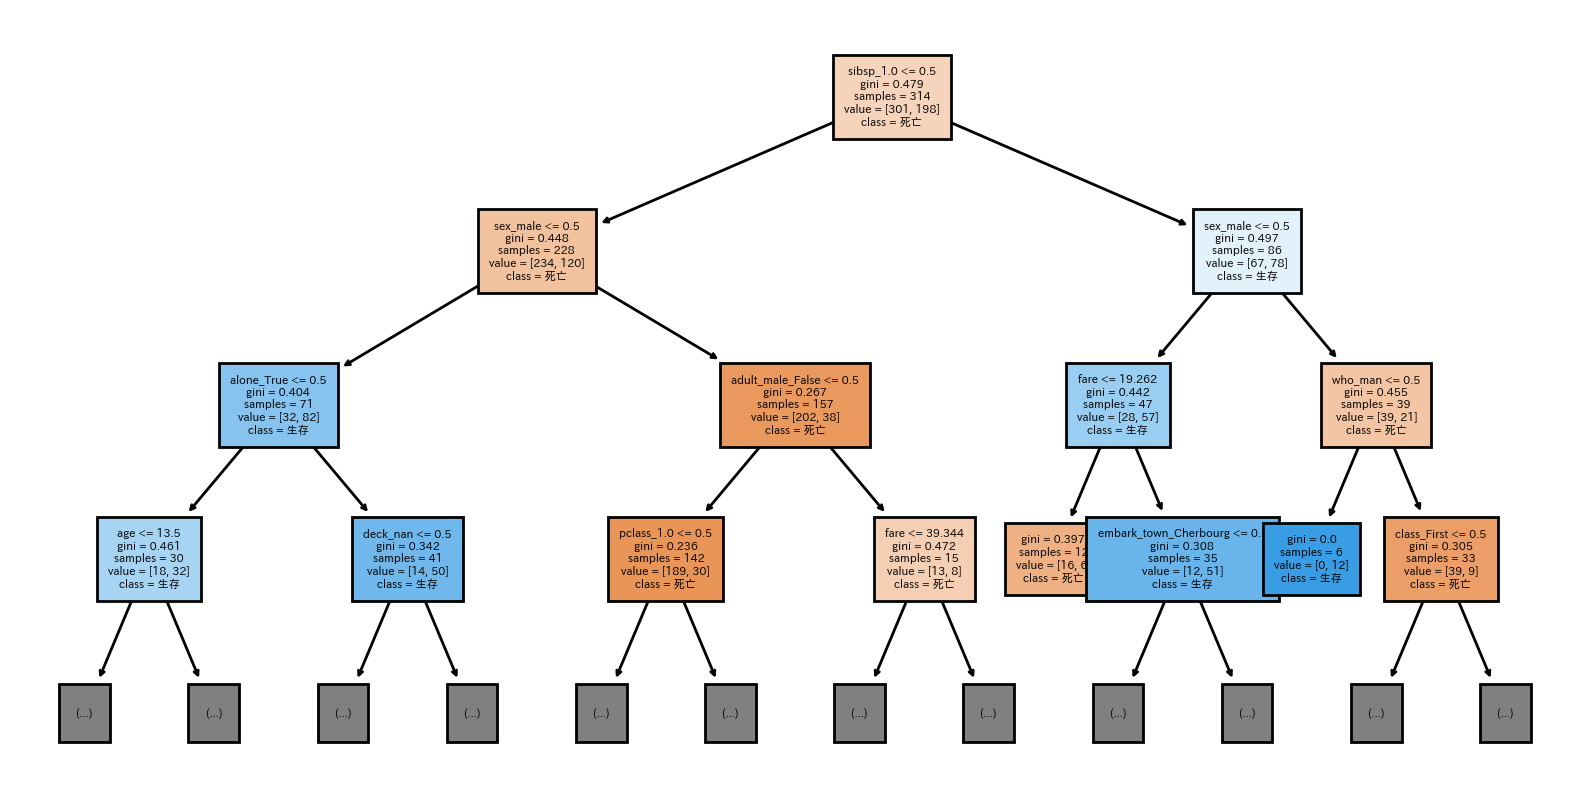

In [83]:
# 可視化の設定
plt.figure(
    figsize=(10, 5), # 描画サイズ
    facecolor='white', # 背景色
    dpi=200 # 解像度
)

# 決定木の可視化
tree.plot_tree(
    decision_tree=estimators[0], # 決定木モデル
    max_depth=3, # 表示する木の深さ
    feature_names=features, # 説明変数名
    class_names=['死亡', '生存'], # 目的変数の各クラス名
    fontsize=4,
    filled=True # ノードに色を付ける
)

## 精度評価

### train

In [84]:
# trainを予測
pred_train_y = rfc.predict(train_x)

# y=1である確率を予測
prob_train_y = rfc.predict_proba(train_x).T[1]

In [85]:
rfc_train_valid_df = pd.DataFrame(
    {
        'prob_y': prob_train_y,
        'pred_y': pred_train_y,
        target: train_y
    }
)
rfc_train_valid_df.head()

,prob_y,pred_y,survived
377,0.348979,0,0
827,0.751425,1,1
89,0.110304,0,0
302,0.132413,0,0
526,0.880794,1,1


In [86]:
# accuracy
rfc_train_accuracy_val = accuracy_score(
    rfc_train_valid_df[target],
    rfc_train_valid_df['pred_y']
)

# auc
rfc_train_auc_val = roc_auc_score(
    rfc_train_valid_df[target],
    rfc_train_valid_df['prob_y']
)

print('accuracy:', rfc_train_accuracy_val)
print('auc:', rfc_train_auc_val)

accuracy: 0.845691382765531
auc: 0.9144137353433834


### test

In [87]:
# testを予測
pred_test_y = rfc.predict(test_x)

# y=1である確率を予測
prob_test_y = rfc.predict_proba(test_x).T[1]

In [88]:
rfc_test_valid_df = pd.DataFrame(
    {
        'prob_y': prob_test_y,
        'pred_y': pred_test_y,
        target: test_y
    }
)
rfc_test_valid_df.head()

,prob_y,pred_y,survived
129,0.148226,0,0
189,0.118728,0,0
555,0.324496,0,0
483,0.395826,0,1
722,0.068223,0,0


In [89]:
# accuracy
rfc_test_accuracy_val = accuracy_score(
    rfc_test_valid_df[target],
    rfc_test_valid_df['pred_y']
)

# auc
rfc_test_auc_val = roc_auc_score(
    rfc_test_valid_df[target],
    rfc_test_valid_df['prob_y']
)

print('accuracy:', rfc_test_accuracy_val)
print('auc:', rfc_test_auc_val)

accuracy: 0.8372093023255814
auc: 0.8980414746543779


## 精度評価の結果を再確認

- 今回作ったモデルについては決定木の方が過学習気味であり，ランダムフォレストの方が汎化性能が高い

In [90]:
print('dtc train accuracy:', dtc_train_accuracy_val)
print('dtc test accuracy:', dtc_test_accuracy_val)
print('=' * 60)
print('rfc train accuracy:', rfc_train_accuracy_val)
print('rfc test accuracy:', rfc_test_accuracy_val)

dtc train accuracy: 0.8717434869739479
dtc test accuracy: 0.827906976744186
rfc train accuracy: 0.845691382765531
rfc test accuracy: 0.8372093023255814


In [91]:
print('dtc train auc:', dtc_train_auc_val)
print('dtc test auc:', dtc_test_auc_val)
print('=' * 60)
print('rfc train auc:', rfc_train_auc_val)
print('rfc test auc:', rfc_test_auc_val)

dtc train auc: 0.9585008375209381
dtc test auc: 0.8481035093938318
rfc train auc: 0.9144137353433834
rfc test auc: 0.8980414746543779


# notebookをhtml化

In [92]:
!jupyter nbconvert --to html ./src/20240831_データ分析と決定木モデル作成_colab.ipynb

[NbConvertApp] Converting notebook ./src/20240831_データ分析と決定木モデル作成_colab.ipynb to html
[NbConvertApp] Writing 746008 bytes to src/20240831_データ分析と決定木モデル作成_colab.html
